In [1]:
import pandas as pd
from pyopenms import MzMLFile, MSExperiment, OnDiscMSExperiment
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
tolerance_margin = 216.042 * 10 / 1e6
print(216.042 - tolerance_margin, 216.042 + tolerance_margin)

216.03983958 216.04416042


In [3]:
def ion_detection(spectrum):
    spectrum_mz, intensities = spectrum.get_peaks()
    lower_border = np.searchsorted(spectrum_mz, 216.042 - tolerance_margin, side="left")
    higher_border = np.searchsorted(spectrum_mz, 216.042 + tolerance_margin, side="right")

    detected_peaks_mz = spectrum_mz[lower_border:higher_border]
    detected_peaks_intensities = intensities[lower_border:higher_border]
    if len(detected_peaks_mz) == 0:
        return None, 0
    max_peak_idx = np.argmax(detected_peaks_intensities)
    max_peak_mz = detected_peaks_mz[max_peak_idx]
    max_peak_intensity = detected_peaks_intensities[max_peak_idx]
    return max_peak_mz, max_peak_intensity

In [4]:
exp = MSExperiment()

MzMLFile().load("../../data/230928_JL_Immonium_ions_Modified_DIA.mzML", exp)
spectra_all = exp.getSpectra()

In [19]:
exp.getPrecursorSpectrum(74)

73

In [5]:
def get_peaks_differences(intensities):
    differences = np.diff(intensities)
    # Leave out the last element because there is no corresponding diff
    peaks_mask = (intensities >= np.mean(intensities)/10)[:-1]
    return differences[peaks_mask]

In [39]:
def get_peaks_differences_for_whole_experiment():
    intensities_diffs = []
    spectrum_idx = 1

    while spectrum_idx < len(spectra_all):
        intensities_per_ms1_spectrum = []
        current_spectrum = spectra_all[spectrum_idx]

        while current_spectrum.getMSLevel() == 2:
            if current_spectrum.getPrecursors()[0].getMetaValue("collision energy") == 50:
                current_ms1_intensity = ion_detection(current_spectrum)[1]
                intensities_per_ms1_spectrum.append(current_ms1_intensity)

            spectrum_idx += 1
            if spectrum_idx == len(spectra_all):
                break
            current_spectrum = spectra_all[spectrum_idx]
        intensities_per_ms1_spectrum = np.array(intensities_per_ms1_spectrum)
        if not np.all(intensities_per_ms1_spectrum == 0):
            print(spectrum_idx)
            intensities_diffs.append(get_peaks_differences(intensities_per_ms1_spectrum))
        spectrum_idx += 1
    return intensities_diffs


In [40]:
diffs_phospho = get_peaks_differences_for_whole_experiment()

2701
3212
3431
3504
3650
3723
3869
4015
4088
4161
4234
4307
4380
4453
4526
4672
4745
4818
6205
6424
6570
6643
6716
6789
6862
6935
7008
7081
7154
7227
7300
7373
7446
7519
7592
7665
7738
7811
7884
7957
8030
8103
8176
8249
8322
8395
8468
8541
8614
8687
8760
8833
8906
8979
9052
9125
9198
9271
9344
9417
9490
9563
9636
9709
9782
9855
9928
10001
10074
10147
10220
10293
10366
10439
10512
10585
10658
10731
10804
10877
10950
11023
11096
11169
11242
11315
11388
11461
11534
11607
11680
11753
11826
11899
11972
12045
12118
12191
12264
12337
12410
12483
12556
12629
12702
12775
12848
12921
12994
13067
13140
13213
13286
13359
13432
13505
13578
13651
13724
13797
13870
13943
14016
14089
14162
14235
14308
14381
14454
14527
14600
14673
14746
14819
14892
14965
15038
15111
15184
15257
15330
15403
15476
15549
15622
15695
15768
15841
15914
15987
16060
16133
16206
16279
16352
16425
16498
16571
16644
16717
16790
16863
16936
17009
17082
17155
17228
17301
17374
17447
17520
17593
17666
17739
17812
17885
17958
18031

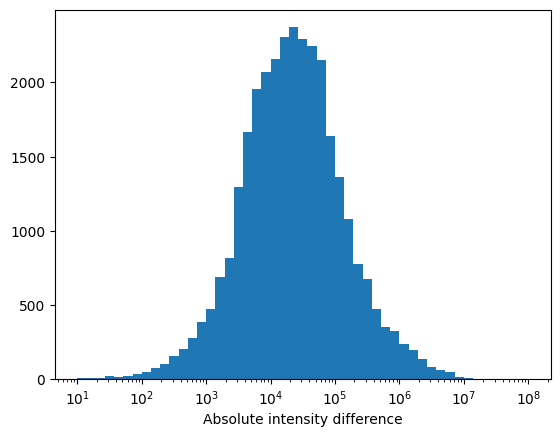

In [51]:
plt.hist(np.abs(np.concatenate(diffs_phospho)), bins=np.logspace(start=1, stop=8))
plt.xscale("log")
plt.xlabel("Absolute intensity difference")
plt.savefig("../../data/plots/ion_intensity_differences_distribution.png", bbox_inches="tight")

In [36]:
diffs_phospho

[array([-3414.86816406]),
 array([-3257.00756836]),
 array([-5170.06640625]),
 array([-3977.52709961]),
 array([-3167.27807617, -3021.23461914]),
 array([-2898.43115234]),
 array([-5122.44433594]),
 array([ 3776.14135742, -6955.57666016]),
 array([   58.62646484,  4585.94433594, -7751.63623047]),
 array([-5751.81591797]),
 array([-4304.05371094]),
 array([  673.7902832 , -4407.02197266, -5145.48144531]),
 array([-5837.09912109]),
 array([-4060.31201172]),
 array([-4398.23535156]),
 array([-4693.18359375]),
 array([-3582.1887207 , -4049.50195312]),
 array([-3608.75512695]),
 array([-3269.98681641]),
 array([-4116.93261719]),
 array([  172.91186523, -3394.11889648]),
 array([ 1034.10742188,  -623.8293457 , -3770.84985352]),
 array([  473.70849609, -3644.6730957 ]),
 array([ 1697.22290039, -2115.86425781, -3617.19433594]),
 array([-2381.73583984,  -257.65136719, -3272.20361328]),
 array([ 3993.45019531, -4626.64477539,   639.51123047, -3649.5637207 ,
        -2648.328125  ]),
 array([-106

In [9]:
def plot_phospho_ions_behaviour_for_spectrum_id_within_ms1_window(s_id_number):
    current_ms1_intensities = []
    previous_ms1_intensities = []
    spectrum_idcs = []
    
    initial_spectrum_idx = [i[0] for i in enumerate(spectra_all) if i[1].getNativeID() == f"controllerType=0 controllerNumber=1 scan={s_id_number}"][0]
    ms1_spectrum_idx = exp.getPrecursorSpectrum(initial_spectrum_idx)
    spectrum_idx = ms1_spectrum_idx + 1

    current_spectrum = spectra_all[spectrum_idx]
    while current_spectrum.getMSLevel() == 2:
        if current_spectrum.getPrecursors()[0].getMetaValue("collision energy") == 50:
            current_ms1_intensity = ion_detection(current_spectrum)[1]
            previous_ms1_intensity = ion_detection(spectra_all[spectrum_idx - 73])[1]
            current_ms1_intensities.append(current_ms1_intensity)
            previous_ms1_intensities.append(previous_ms1_intensity)
            spectrum_idcs.append(spectrum_idx)

        spectrum_idx += 1
        current_spectrum = spectra_all[spectrum_idx]

    plt.figure(figsize=(6, 4))
    #plt.plot(spectrum_idcs, previous_ms1_intensities, label="immonium ions in windows for previous MS1 window", marker="o", color="orange")
    plt.plot(spectrum_idcs, current_ms1_intensities, marker="o")
    plt.xlabel("Spectrum ID")
    plt.ylabel("Phospho ion intensity")
    plt.title("Phospho ion intensity over the MS2 windows\nof one MS1 spectrum")
    plt.savefig(f"../../data/plots/ion_intensity_over_windows_example_{s_id_number}.png", bbox_inches="tight")
    
    #plt.legend(loc="upper right")

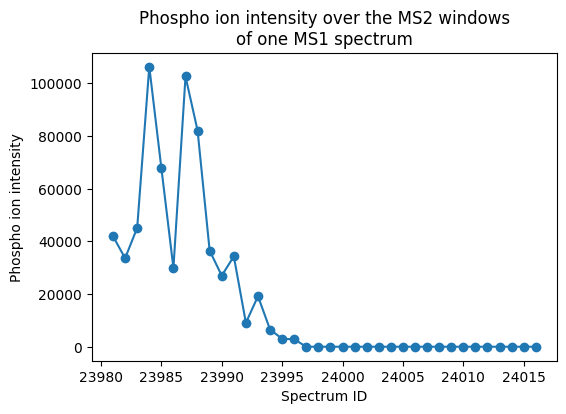

In [11]:
plot_phospho_ions_behaviour_for_spectrum_id_within_ms1_window(24000)